I will construct three model and use three targets:
* Age
* Gender
* Ethnicity

After training models I'm going to create a function which will predict these three parameters by photo.

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
pip install -q pyyaml h5py  

So, there are three targets:

Age: range from 1 to 116 <br>
Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other  <br>
Gender: 0 - male, 1 - female <br>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/face/age_gender.csv')

In [7]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


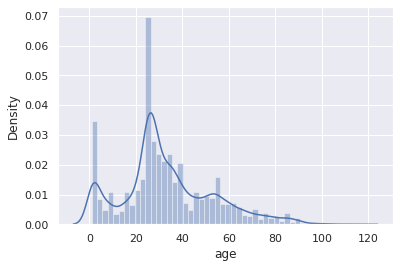

In [9]:
# Age
sns.distplot(df['age']);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


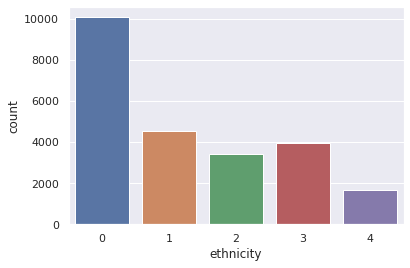

In [10]:
# Ethnicity
sns.countplot(df['ethnicity']);

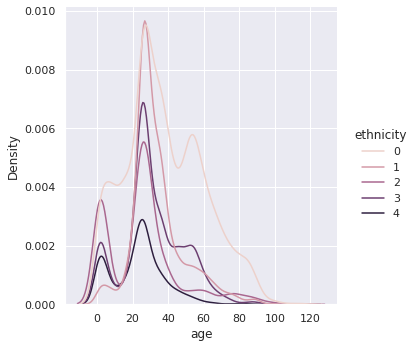

In [11]:
sns.displot(data=df, x="age", hue="ethnicity", kind="kde")

In [12]:
df.value_counts(df['ethnicity'])

ethnicity
0    10078
1     4526
3     3975
2     3434
4     1692
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


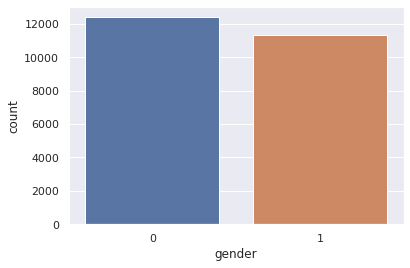

In [13]:
# Gender
sns.countplot(df['gender']);

Actually imaeges in dataset are in string format, let's transform it in more useful type of data.

In [14]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

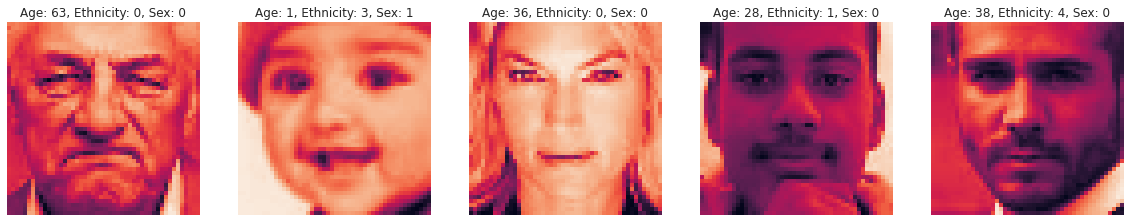

In [15]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')


## CNN

In [16]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [17]:
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

In [18]:
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

n_epochs = 25
batch_size = 32

## Age prediction

So let's start with age prediction. 

In [19]:
# Set y
y = df['age'].values

In [20]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [21]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0

In [22]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [23]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/25
593/593 [==============================] - 12s 9ms/step - loss: 226.9825 - val_loss: 604.5142 - lr: 0.0010
Epoch 2/25
593/593 [==============================] - 5s 8ms/step - loss: 143.4431 - val_loss: 2951.1931 - lr: 0.0010
Epoch 3/25
592/593 [============================>.] - ETA: 0s - loss: 127.1397
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
593/593 [==============================] - 5s 8ms/step - loss: 127.0427 - val_loss: 2105.9045 - lr: 0.0010
Epoch 4/25
593/593 [==============================] - 5s 8ms/step - loss: 100.5383 - val_loss: 98.8731 - lr: 1.0000e-04
Epoch 5/25
593/593 [==============================] - 5s 8ms/step - loss: 93.8063 - val_loss: 91.8445 - lr: 1.0000e-04
Epoch 6/25
593/593 [==============================] - 5s 8ms/step - loss: 89.6012 - val_loss: 96.1659 - lr: 1.0000e-04
Epoch 7/25
593/593 [==============================] - 5s 8ms/step - loss: 86.1168 - val_loss: 77.7684 - lr: 1.0000e-04
Epoch 8/25
593/593 [====

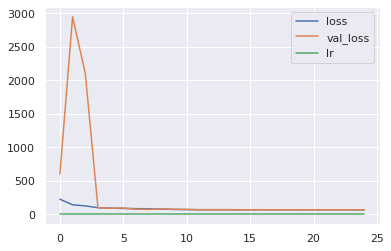

In [24]:
pd.DataFrame(history.history).plot();

In [25]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 0s 3ms/step - loss: 69.5962


In [26]:
# Make predictions 
y_pred = age_model.predict(X_test)

149/149 [==============================] - 1s 3ms/step


In [27]:
# Man absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.928352607928407


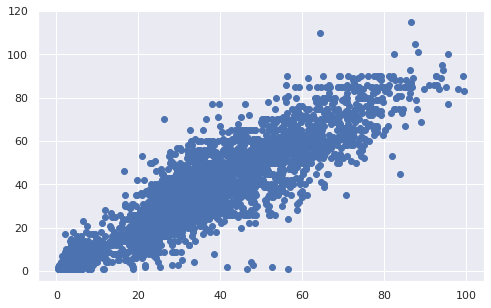

In [28]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

So, mean absolute error around 5.5 years it's not so super result considering mean age is 33, it's about 17%.

## Gender prediction

In [29]:
# Set y
y = df['gender'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [30]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 128)       

In [31]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [32]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                          batch_size= batch_size,
                           callbacks=callbacks,
                          validation_data=(X_test, y_test))



Epoch 1/25
593/593 [==============================] - 8s 8ms/step - loss: 0.5063 - accuracy: 0.7601 - val_loss: 0.4567 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 2/25
593/593 [==============================] - 4s 7ms/step - loss: 0.3548 - accuracy: 0.8405 - val_loss: 0.3571 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 3/25
593/593 [==============================] - 4s 8ms/step - loss: 0.3192 - accuracy: 0.8552 - val_loss: 0.3151 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 4/25
593/593 [==============================] - 4s 7ms/step - loss: 0.3001 - accuracy: 0.8668 - val_loss: 0.4197 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/25
593/593 [==============================] - 4s 7ms/step - loss: 0.2798 - accuracy: 0.8776 - val_loss: 0.2958 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 6/25
593/593 [==============================] - 5s 8ms/step - loss: 0.2707 - accuracy: 0.8825 - val_loss: 0.2550 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 7/25
593/593 [==============================] - 4s 7ms/step - lo

In [33]:
# Metrics
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 0s 3ms/step - loss: 0.2362 - accuracy: 0.9076
Accuracy for test set: 0.9076144099235535


In [34]:
y_pred = gender_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

149/149 [==============================] - 0s 2ms/step


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2468
           1       0.91      0.90      0.90      2273

    accuracy                           0.91      4741
   macro avg       0.91      0.91      0.91      4741
weighted avg       0.91      0.91      0.91      4741



I suppose big part of this mistakes is children. Let's see some examples where's model had made mistake.

In [36]:
y_pred = y_pred.reshape(y_pred.shape[0])

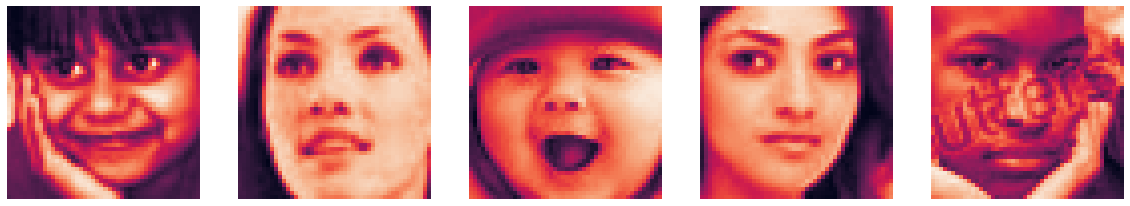

In [37]:
# Model predict is female, but actually it's male

X_fp = X_test[(y_pred == 1) & (y_test == 0)] 

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fp))
    
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

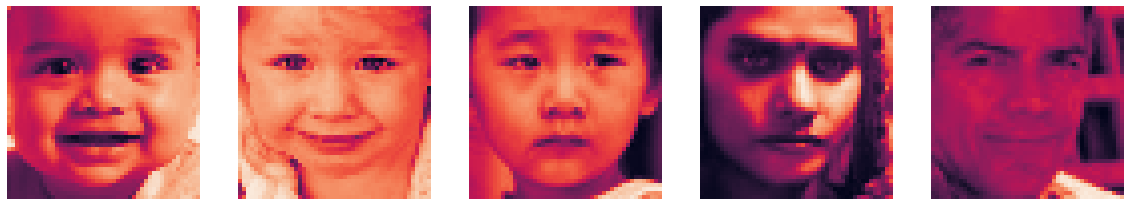

In [38]:
# Model predict is male, but actually it's female

X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

So, on many photos difference between genders are not so clear.

## Ethnicity prediction

In [39]:
# Set y
y = df['ethnicity'].values

# Multiclass problem transform to one_hot_encoding
y = to_categorical(y, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [40]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

eth_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                      

In [41]:
# Callbacks for ethnicity model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [42]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/25
593/593 [==============================] - 7s 7ms/step - loss: 1.1560 - accuracy: 0.5844 - val_loss: 1.3411 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 2/25
593/593 [==============================] - 3s 6ms/step - loss: 0.8882 - accuracy: 0.6836 - val_loss: 0.8813 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 3/25
593/593 [==============================] - 4s 6ms/step - loss: 0.8046 - accuracy: 0.7222 - val_loss: 0.6855 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 4/25
593/593 [==============================] - 4s 6ms/step - loss: 0.7399 - accuracy: 0.7429 - val_loss: 0.7136 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 5/25
593/593 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.7605 - val_loss: 0.6735 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 6/25
593/593 [==============================] - 3s 6ms/step - loss: 0.6555 - accuracy: 0.7759 - val_loss: 1.0192 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 7/25
588/593 [============================>.] - ETA: 0s - loss: 

In [43]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 0s 3ms/step - loss: 0.5637 - accuracy: 0.8140


In [44]:
y_pred = eth_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

149/149 [==============================] - 0s 2ms/step


In [45]:
# Convert to 0 to 4 scale 
y_test_labels = np.round(y_test).astype(int)

In [46]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2047
           1       0.89      0.80      0.84       904
           2       0.89      0.82      0.85       657
           3       0.81      0.71      0.76       804
           4       0.64      0.04      0.08       329

   micro avg       0.87      0.76      0.81      4741
   macro avg       0.82      0.64      0.68      4741
weighted avg       0.85      0.76      0.79      4741
 samples avg       0.76      0.76      0.76      4741



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(age_model.predict(x))
    gender_predict = int(np.round(gender_model.predict(x)))
    ethnicity_predict = int(np.argmax(eth_model.predict(x), axis=1))

    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    
    plt.imshow(image)
    plt.title('{0}, {1}, {2}'.format(age_predict, gender[gender_predict], eth_group[ethnicity_predict]))
    plt.axis('off')

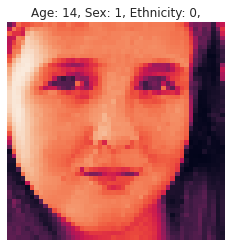

In [48]:
# Final check
random_face = np.random.choice(len(df))

age = df['age'][random_face]
ethnicity = df['ethnicity'][random_face]
gender = df['gender'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

1/1 [==============================] - 0s 31ms/step


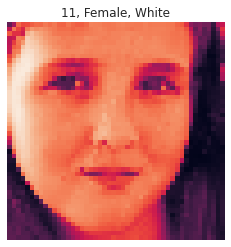

In [49]:
# Model prediction 
face_prediction(df['pixels'][random_face])

In [50]:
age_model.save_weights('/content/gdrive/MyDrive/age.h5')
gender_model.save_weights('/content/gdrive/MyDrive/gender.h5')
eth_model.save_weights('/content/gdrive/MyDrive/eth.h5')

In [51]:
age_model.save('/content/gdrive/MyDrive/age_normal.h5')
gender_model.save('/content/gdrive/MyDrive/gender_normal.h5')
eth_model.save('/content/gdrive/MyDrive/eth_normal.h5')

In [52]:
from keras.models import load_model

age_model = load_model("/content/gdrive/MyDrive/face/age_normal.h5")
age_model.load_weights("/content/gdrive/MyDrive/face/age.h5")

eth_model = load_model("/content/gdrive/MyDrive/face/eth_normal.h5")
eth_model.load_weights("/content/gdrive/MyDrive/face/eth.h5")

gender_model = load_model("/content/gdrive/MyDrive/face/gender_normal.h5")
gender_model.load_weights("/content/gdrive/MyDrive/face/gender.h5")

In [53]:
def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(age_model.predict(x))
    gender_predict = int(np.round(gender_model.predict(x)))
    ethnicity_predict = int(np.argmax(eth_model.predict(x), axis=-1))
    
    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    
    plt.imshow(image)
    plt.title('{0}, {1}, {2}'.format(age_predict, gender[gender_predict], eth_group[ethnicity_predict]))
    plt.axis('off')

In [54]:
from PIL import Image
basewidth = 48
img = Image.open("/content/claude_.jpg").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)

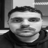

In [55]:
im2

In [56]:
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

data

array([[ 16.,  13.,  15., ...,  98.,  96.,  96.],
       [ 17.,  14.,  15., ..., 102., 104., 102.],
       [ 19.,  16.,  16., ..., 171., 162., 186.],
       ...,
       [ 43.,  43.,  43., ...,  53.,  49.,  43.],
       [ 44.,  43.,  43., ...,  50.,  48.,  40.],
       [ 41.,  41.,  43., ...,  49.,  49.,  40.]], dtype=float32)

1/1 [==============================] - 0s 118ms/step


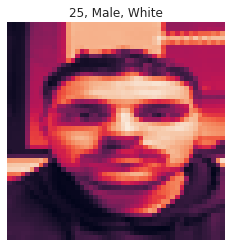

In [57]:
face_prediction(data)

1/1 [==============================] - 0s 23ms/step


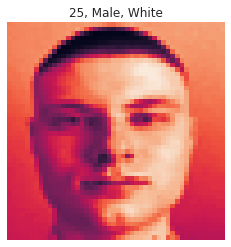

In [58]:
from PIL import Image
basewidth = 48
img = Image.open("/content/valentin_magicien.png").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

1/1 [==============================] - 0s 22ms/step


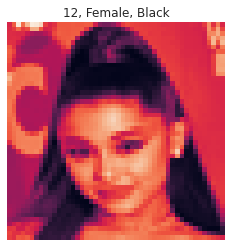

In [59]:
from PIL import Image
basewidth = 48
img = Image.open("/content/ariana.jpg").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

1/1 [==============================] - 0s 22ms/step


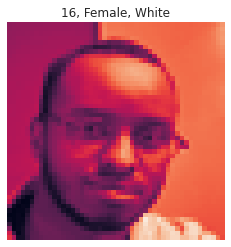

In [60]:
from PIL import Image
basewidth = 48
img = Image.open("/content/farhan_.png").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

So our model works quite well on whites, but on other ethnicities there are some problems. Let's try to rebalance our dataset.

In [61]:
df = pd.read_csv('/content/gdrive/MyDrive/face/age_gender.csv')

In [62]:
df_filtered1 = df[df['ethnicity'] == 1]
df_filtered2 = df[df['ethnicity'] == 2]
df_filtered3 = df[df['ethnicity'] == 3]
df_filtered4 = df[df['ethnicity'] == 4]
df_filtered5 = df[df['ethnicity'] == 4]
df_filtered6 = df[df['ethnicity'] == 4]
df_filtered7 = df[df['ethnicity'] == 4]
df_filtered8 = df[df['ethnicity'] == 4]
df_filtered9 = df[df['ethnicity'] == 3]

# Concatenate the original DataFrame with the filtered DataFrame
df_remake = pd.concat([df, df_filtered1], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered2], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered2], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered3], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered4], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered5], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered6], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered7], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered8], ignore_index=True)
df_remake = pd.concat([df_remake, df_filtered9], ignore_index=True)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


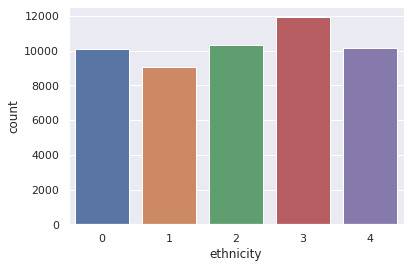

In [63]:
sns.countplot(df_remake['ethnicity']);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

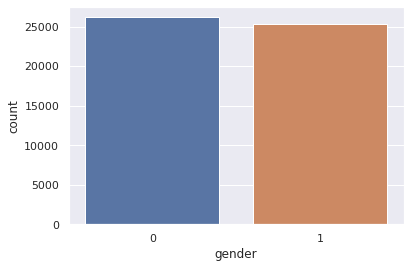

In [64]:
sns.countplot(df_remake['gender'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


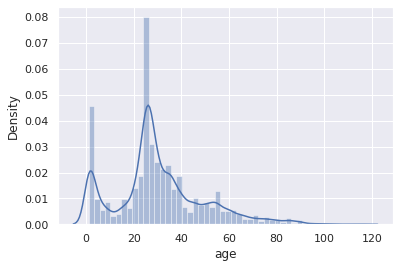

In [65]:
sns.distplot(df_remake['age']);

In [66]:
df_remake['pixels'] = df_remake['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [67]:
X = np.array(df_remake['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [68]:
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
input_shape = X_reshaped.shape[1:] 

n_epochs = 20
batch_size = 64

In [69]:
y = df_remake['age'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [70]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 128)     

In [71]:
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [72]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/20
644/644 [==============================] - 10s 10ms/step - loss: 160.1097 - val_loss: 194.9403 - lr: 0.0010
Epoch 2/20
644/644 [==============================] - 6s 9ms/step - loss: 98.6301 - val_loss: 305.3441 - lr: 0.0010
Epoch 3/20
644/644 [==============================] - 6s 9ms/step - loss: 83.7744 - val_loss: 83.9081 - lr: 0.0010
Epoch 4/20
644/644 [==============================] - 6s 9ms/step - loss: 77.1460 - val_loss: 266.3808 - lr: 0.0010
Epoch 5/20
643/644 [============================>.] - ETA: 0s - loss: 68.8808
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
644/644 [==============================] - 6s 9ms/step - loss: 68.8764 - val_loss: 471.0317 - lr: 0.0010
Epoch 6/20
644/644 [==============================] - 6s 9ms/step - loss: 55.6352 - val_loss: 41.6583 - lr: 1.0000e-04
Epoch 7/20
644/644 [==============================] - 6s 9ms/step - loss: 51.2599 - val_loss: 52.6271 - lr: 1.0000e-04
Epoch 8/20
641/644 [================

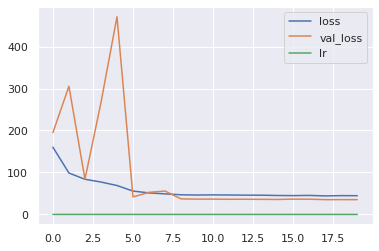

In [73]:
pd.DataFrame(history.history).plot();

In [74]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

322/322 [==============================] - 1s 3ms/step - loss: 35.1904


In [75]:
y_pred = age_model.predict(X_test)

322/322 [==============================] - 1s 3ms/step


In [76]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 4.069511820646981


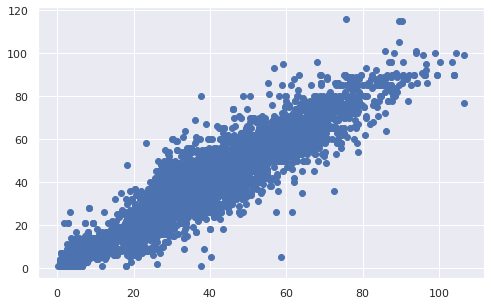

In [77]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

In [78]:
y = df_remake['gender'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [79]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 9, 9, 128)       

In [80]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [81]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                          batch_size= batch_size,
                           callbacks=callbacks,
                          validation_data=(X_test, y_test))

Epoch 1/20
644/644 [==============================] - 9s 9ms/step - loss: 0.4304 - accuracy: 0.7990 - val_loss: 0.3360 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 2/20
644/644 [==============================] - 5s 8ms/step - loss: 0.3051 - accuracy: 0.8661 - val_loss: 0.2923 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 3/20
644/644 [==============================] - 5s 8ms/step - loss: 0.2736 - accuracy: 0.8801 - val_loss: 0.2604 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 4/20
644/644 [==============================] - 5s 8ms/step - loss: 0.2502 - accuracy: 0.8917 - val_loss: 0.2516 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 5/20
644/644 [==============================] - 5s 8ms/step - loss: 0.2286 - accuracy: 0.9022 - val_loss: 0.2045 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 6/20
644/644 [==============================] - 5s 8ms/step - loss: 0.2122 - accuracy: 0.9097 - val_loss: 0.2034 - val_accuracy: 0.9195 - lr: 0.0010
Epoch 7/20
644/644 [==============================] - 5s 8ms/step - lo

In [82]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

322/322 [==============================] - 1s 3ms/step - loss: 0.0997 - accuracy: 0.9674
Accuracy for test set: 0.9673849940299988


In [83]:
y_pred = gender_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

322/322 [==============================] - 1s 2ms/step


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5248
           1       0.97      0.97      0.97      5054

    accuracy                           0.97     10302
   macro avg       0.97      0.97      0.97     10302
weighted avg       0.97      0.97      0.97     10302



In [85]:
y = df_remake['ethnicity'].values

# Multiclass problem transform to one_hot_encoding
y = to_categorical(y, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [86]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

eth_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                      

In [87]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [88]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/20
644/644 [==============================] - 8s 7ms/step - loss: 1.1637 - accuracy: 0.5478 - val_loss: 0.9606 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 2/20
644/644 [==============================] - 4s 6ms/step - loss: 0.8738 - accuracy: 0.6715 - val_loss: 0.7931 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 3/20
644/644 [==============================] - 4s 6ms/step - loss: 0.7469 - accuracy: 0.7230 - val_loss: 0.6517 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 4/20
644/644 [==============================] - 4s 6ms/step - loss: 0.6521 - accuracy: 0.7617 - val_loss: 0.9088 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 5/20
644/644 [==============================] - 4s 6ms/step - loss: 0.5681 - accuracy: 0.7941 - val_loss: 0.5036 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 6/20
644/644 [==============================] - 4s 6ms/step - loss: 0.5006 - accuracy: 0.8226 - val_loss: 0.4455 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 7/20
644/644 [==============================] - 4s 6ms/step - lo

In [89]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

322/322 [==============================] - 1s 3ms/step - loss: 0.1473 - accuracy: 0.9558


In [90]:
y_pred = eth_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

322/322 [==============================] - 1s 2ms/step


In [91]:
y_test_labels = np.round(y_test).astype(int)

In [92]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1981
           1       0.97      0.95      0.96      1804
           2       0.97      0.98      0.98      2165
           3       0.94      0.99      0.97      2337
           4       0.94      1.00      0.97      2015

   micro avg       0.96      0.95      0.96     10302
   macro avg       0.96      0.95      0.95     10302
weighted avg       0.96      0.95      0.96     10302
 samples avg       0.95      0.95      0.95     10302



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
age_model.save_weights('/content/gdrive/MyDrive/age_boost.h5')
gender_model.save_weights('/content/gdrive/MyDrive/gender_boost.h5')
eth_model.save_weights('/content/gdrive/MyDrive/eth_boost.h5')
age_model.save('/content/gdrive/MyDrive/age_normal_boost.h5')
gender_model.save('/content/gdrive/MyDrive/gender_normal_boost.h5')
eth_model.save('/content/gdrive/MyDrive/eth_normal_boost.h5')

1/1 [==============================] - 0s 22ms/step


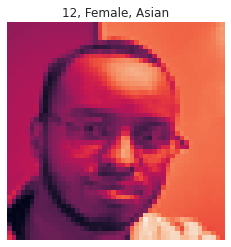

In [94]:
from PIL import Image
basewidth = 48
img = Image.open("/content/farhan_.png").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

1/1 [==============================] - 0s 21ms/step


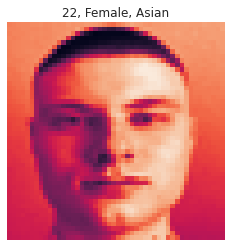

In [95]:
from PIL import Image
basewidth = 48
img = Image.open("/content/valentin_magicien.png").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

1/1 [==============================] - 0s 24ms/step


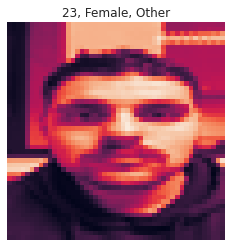

In [96]:
from PIL import Image
basewidth = 48
img = Image.open("/content/claude_.jpg").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

1/1 [==============================] - 0s 22ms/step


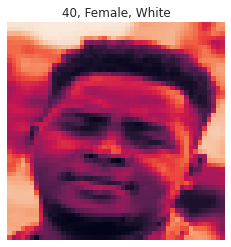

In [108]:
from PIL import Image
basewidth = 48
img = Image.open("/content/roudnel.png").convert('L')
im2 = img.resize((48,48),resample=Image.BICUBIC)
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
data = np.array(im2,"float32")

face_prediction(data)

In [98]:
pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
from deepface import DeepFace

DeepFace.analyze("/content/farhan_.png")

gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [01:59<00:00, 4.49MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [01:34<00:00, 5.69MB/s]
Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


[{'emotion': {'angry': 0.03366701893100662,
   'disgust': 2.6617321490770413e-09,
   'fear': 0.002395649686147776,
   'happy': 0.005283607340486032,
   'sad': 0.04019514411224197,
   'surprise': 0.0014129952567562994,
   'neutral': 99.91704226529095},
  'dominant_emotion': 'neutral',
  'region': {'x': 55, 'y': 120, 'w': 352, 'h': 352},
  'age': 30,
  'gender': {'Woman': 0.15300106024369597, 'Man': 99.84700083732605},
  'dominant_gender': 'Man',
  'race': {'asian': 0.45158551074564457,
   'indian': 3.773404285311699,
   'black': 94.6886658668518,
   'white': 0.029795095906592906,
   'middle eastern': 0.025806218036450446,
   'latino hispanic': 1.0307412594556808},
  'dominant_race': 'black'}]